# 4. Significance Testing for Continuous Metrics (Bayesian Approach)

This chapter will discuss a method described by [Kruschke (2013)](https://pdfs.semanticscholar.org/dea6/0927efbd1f284b4132eae3461ea7ce0fb62a.pdf) known as BEST (Bayesian Estimation Supersedes the T-test), which uses pre-determined model parameters in conjunction with our known (posterior) data to generate credible posterior distributions using Markov Chain Monte-Carlo simulations with pymc3. This method is the Bayesian equivalent to the t-test and provides some of the outputs previously discussed that frequentist statistics fail to provide. So this may may be your preferred method for explaining the results of your experiment to your stakeholders, if you are working with continuous data. 

When performing BEST analysis, we must set some pre-determined model parameters, using a distribution for our priors that best suites/explains our posterior (known) data. Note that in both this example and methods conducted by Kruschke, data are described by a Student-t distribution. Although this is not always appropriate, utilising a t-distribution can be more informative than a normal distribution, as it describes data as pertaining a tail; which is often the case with continuous metrics extrapolated from web data (that is “super users” often exist). It is worth pointing out that you may want to tweak the following code if this does not apply to your data:

![](t_vs_normal_3.png)

To describe a [Student-t distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution), you need both mean μ (normal distribution) and standard deviation σ (uniform distribution) inputs. You will also need to specify the degree of freedom ν, which follows a shifted exponential distribution. The normality of the data is mediated by ν. If ν => 30, then the computed distribution is close to a normal distribution; therefore the value of 1/29 is used as a normality threshold.

All of this information will be input below, this image from Kruschke may help you visualise the model parameters and how they inform our posterior distributions:

![](model_best_4.png)


But first - import necessary packages for analysis (are you bored of me saying thise yet?):

In [1]:
!pip install --no-progress-bar pymc3


Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: --no-progress-bar


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
import requests
import numpy as np
import pymc3 as pm
import scipy.stats as stat
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
import theano.tensor as tt
from scipy.stats.mstats import mquantiles
import statistics

Import your browser level data (each row will represent a unique id or cookie id):

In [4]:
local = 'keanu_df.csv'
df = pd.read_csv(local, encoding='unicode_escape')
df.head(100)

,unique_cookie_id,Variant,Pvs_per_session
0,##kdjdsvbnkdf,Control_Matrix,2.343523
1,kldvnlkaefv,Control_Matrix,1.234300
2,nvaljkdfnvkld4798,Control_Matrix,3.353000
3,shanuf9v354###nkas,Control_Matrix,3.319751
4,nbncjkbd,Control_Matrix,3.824490
...,...,...,...
95,dkvhjdk844,Control_Matrix,8.367136
96,sjhkjfhbdwjkv,Control_Matrix,8.871875
97,kldvnlkaefv,Control_Matrix,9.376613
98,nvaljkdfnvkld4805,Control_Matrix,9.881352


You may want to group by count to ensure you have equally weighted experimental groups, in order to ascertain you have grouped/collected the data correctly:

In [5]:
df.groupby(['Variant']).count()

,unique_cookie_id,Pvs_per_session
Variant,,
Control_Matrix,99,99
Variant_BT,100,100


You can now check the overall mean values for the Pvs_per_session metric:

In [6]:
df.groupby(['Variant']).mean()

,Pvs_per_session
Variant,
Control_Matrix,5.726181
Variant_BT,7.670531


## Cleaning data - Remove Outliers

Here we will look to remove data + 3 standard deviations from the mean for Pvs_per_session; this is a scientific standard and alligns with stats engines from numerous online A/B testing platforms. First identify the standard deviation for Pvs_per_session:

In [7]:
std = statistics.stdev(df.Pvs_per_session)
print ("Standard deviation of experiment metric is % s"
    % round(std,4))

Standard deviation of experiment metric is 3.0591


Identify data > 3 standard deviations:

In [8]:
outliers = 3 * std

print("Remove data from data-frame that is % s above the mean of the data"
     % round(outliers,4))

Remove data from data-frame that is 9.1774 above the mean of the data


New data-frame that omits this range and look at new computed means:

In [9]:
df_filtered = df[(df['Pvs_per_session'] <  outliers)]
df_filtered.groupby(['Variant']).mean()

,Pvs_per_session
Variant,
Control_Matrix,5.338705
Variant_BT,5.465452


Create seperate frames for variants:

In [10]:
Control_Matrix = df_filtered[(df_filtered['Variant'] == 'Control_Matrix')]
Variant_BT = df_filtered[(df_filtered['Variant'] == 'Variant_BT')]

Set the pooled mean and standard deviation and degrees of freedom parameters:

In [11]:
pooled_mean = np.r_[Control_Matrix.Pvs_per_session, Variant_BT.Pvs_per_session].mean()
pooled_std = np.r_[Control_Matrix.Pvs_per_session, Variant_BT.Pvs_per_session].std()
variance = 2 * pooled_std

Fit the model into your data and run the MCMC simulations to calculate a series of posterior distributions:

In [12]:
with pm.Model() as model_1:
    mu_A = pm.Normal("mu_A", pooled_mean, sd = variance)
    mu_B = pm.Normal("mu_B", pooled_mean, sd = variance)
    std_A = pm.Uniform("std_A", 1/100, 100)
    std_B = pm.Uniform("std_B", 1/100, 100)
    nu_minus_1 = pm.Exponential("nu-1", 1.0/29)

WARNING (theano.gof.compilelock): Overriding existing lock by dead process '87659' (I am process '87917')


In [13]:
with model_1:
    obs_A = pm.StudentT("obs_A", mu = mu_A, lam = 1.0/std_A**2, nu = nu_minus_1+1, observed = Control_Matrix.Pvs_per_session)
    obs_B = pm.StudentT("obs_B", mu = mu_B, lam = 1.0/std_B**2, nu = nu_minus_1+1, observed = Variant_BT.Pvs_per_session)
    start = pm.find_MAP()
    step = pm.Metropolis(vars=[mu_A, mu_B, std_A, std_B, nu_minus_1])
    trace_1 = pm.sample(25000, step=step)
    burned_trace_1 = trace_1[10000:]

You can now visualise the posterior distribution of the group means:

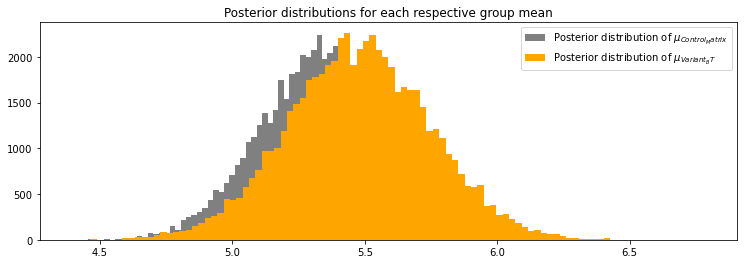

In [14]:
figsize(12.5, 4)
control_mean = burned_trace_1['mu_A']
variant_mean = burned_trace_1['mu_B']
plt.hist(control_mean, bins = 100, label=r'Posterior distribution of $\mu_{Control_Matrix}$', color = 'grey')
plt.hist(variant_mean, bins = 100, label=r'Posterior distribution of $\mu_{Variant_BT}$', color = 'orange')
plt.title('Posterior distributions for each respective group mean')
plt.legend()
plt.show()

And, standard deviations:

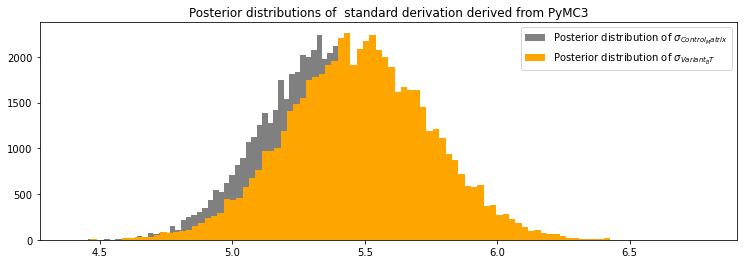

In [15]:
figsize(12.5, 4)
control_std = burned_trace_1['mu_A']
variant_std = burned_trace_1['mu_B']
plt.hist(control_std, bins = 100, label=r'Posterior distribution of $\sigma_{Control_Matrix}$', color = 'grey')
plt.hist(variant_std, bins = 100, label=r'Posterior distribution of $\sigma_{Variant_BT}$',  color = 'orange')
plt.title('Posterior distributions of  standard derivation derived from PyMC3')
plt.legend()
plt.show()

You can now plot the posterior distribution for the difference between groups. We have red lines that represent our highest density intervals (HDI), which encompasses the points with the greatest probability density (that is the samples that are more likely than that outside the parameters passed). Although not to be confused with confidence intervals, this 95% interval can be adjusted to any given range specifided. Secondly, we have our region of practical equivalence (ROPE), which is a pre-determined range of sampled differences between experimental groups. This value will likely be determined by stakeholders and/or analysts beforehand and will be a value we look to exceed. To achieve this we would want the entire ROPE range to fall outside our 95% HDI as this is where the highest probability outcomes exist:

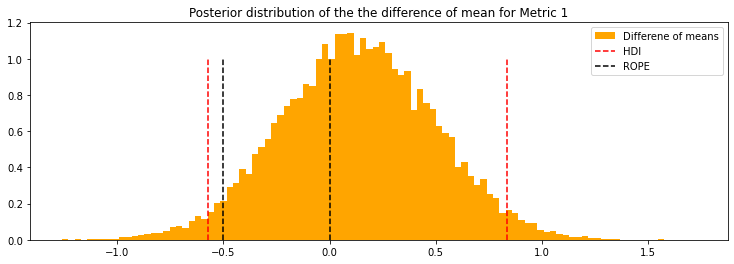

In [16]:
figsize(12.5, 4)

difference = variant_mean - control_mean # Difference of the means


hdi = pm.stats.hpd(difference, hdi_prob = 0.95) # The 95% HDI interval of the difference


rope = [-0.5, 0] #the ROPE region 


plt.hist(difference, bins=100, density=True, label='Differene of means', color = 'orange')
plt.title('Posterior distribution of the the difference of the means')
plt.vlines(hdi[0], 0,1, linestyle = '--', color='red', label='HDI')
plt.vlines(hdi[1], 0, 1, linestyle = '--', color='red')
plt.vlines(rope[0], 0, 1, linestyle = '--', color='black', label='ROPE')
plt.vlines(rope[1], 0, 1, linestyle = '--', color='black')
plt.title('Posterior distribution of the the difference of mean for Metric 1')
plt.legend(loc='upper right')
plt.show()

Finally, we can plot the posterior distribution for the relative difference between experimental conditions:

The probability that the variant performed 1% greater than the control is: 58.47%


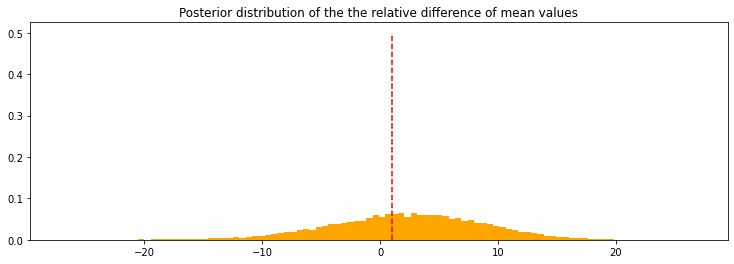

In [17]:
figsize(12.5, 4)

rel_difference = 100 * (variant_mean-control_mean)/variant_mean # Relative difference of the means

prob=len(rel_difference[rel_difference > 1])/len(rel_difference)
plt.hist(rel_difference, bins = 100, density = True, label='Relative differene of the mean metric', color = 'orange')
plt.title('Posterior distribution of the the relative difference of mean values')
plt.vlines(1, 0,0.5, linestyle='--', color = 'red', label='HDI')
print(f"The probability that the variant performed 1% greater than the control is: {round(prob*100,2)}%")
plt.show()

You can see here the probability that the variant beat the control by a certain threshold. It can be determined that there is a ~58% probability that the variant is 1% greater than the baseline. This would be deemed a flat result as the odds the variant performed better is only just greater than a coin flip. This threshold can be changed to whatever is practically important to your stakeholders/wider team, which is both invaluable in a commercial setting and unattainable using frequentist methods.


In the next chapter, we will be looking at methods to reduce variance prior to post-hoc testing, these methods can increase experiment sensitivity/power; meaning you can conclude experiments at a greater velocity.